# N-step Deep Q-Networks
__N-step Deep Q-Networks__ (N-step DQN) is an extension of the classic Deep Q-Network (DQN) algorithm that __incorporates the concept of multi-step returns__ to improve sample efficiency and enhance learning stability. __The idea behind N-step DQN is to estimate the Q-value of a state-action pair by considering the cumulative reward obtained over multiple consecutive time steps__, rather than just the immediate next time step.


__Components__:

1. N-step Return:
  - In traditional DQN, the update is based on the one-step return, which considers only the immediate reward and the estimated Q-value of the next state.
  - In N-step DQN, the update is based on the N-step return, where the cumulative reward and the estimated Q-values for the next N states are considered.

2. N-step Return Calculation:
  - The N-step return is calculated as follows:
  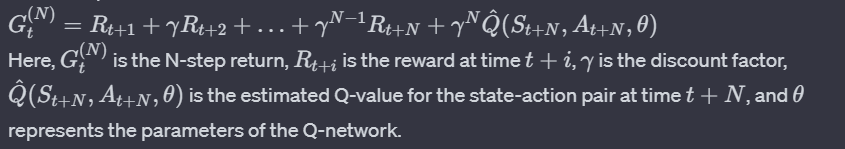

3. Update Rule:
  - The Q-value is updated using the N-step return as the target:
  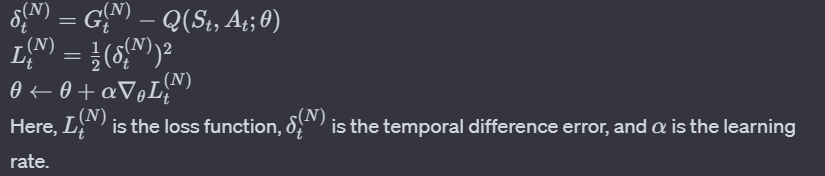

4. N-step Transition:
  - In each training step, a sample of N consecutive transitions $(S_t,A_t,R_{t+_1},S_{t+_1}, A_{t+1},..., R_{t+_N},S_{t+_N})$ is used to calculate the N-step return.

5. N-step Buffer:
  - An N-step buffer is used to store the N-step transitions. This buffer is updated similarly to the traditional experience replay buffer but stores sequences of N-step transitions.

6. Benefits:
  - N-step DQN is known to improve the stability and convergence speed of the learning process.
  - It allows the algorithm to bootstrap information over a longer horizon, capturing more information about the environment.
7. Trade-off:
  - The choice of the parameter N involves a trade-off. Larger values of N can potentially lead to better estimates but might increase the variance of the updates.

In [ ]:
!apt-get install -y xvfb

!pip install \
  gym[atari,accept-rom-license]==0.23.1 \
  pytorch-lightning==1.6.0 \
  stable-baselines3 \
  pyvirtualdisplay

#### Setup virtual display

In [ ]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

#### Import the necessary code libraries

In [ ]:
import copy
import torch
import random
import gym
import matplotlib

import numpy as np
import matplotlib.pyplot as plt

import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule, Trainer

from gym.wrappers import TransformObservation, NormalizeObservation, \
  NormalizeReward, RecordVideo, RecordEpisodeStatistics, AtariPreprocessing


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [ ]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

#### Create the Deep Q-Network

In [ ]:
import math
from torch.nn.init import kaiming_uniform_, zeros_

class NoisyLinear(nn.Module):
  """
  Noisy Linear layer (Layer from the DQN).

  The job of that layer is to pass noise to the weigths of the layer,
  for balance between exploration and exploitation.

  The benefits here, that the noise is part from the weigths, and its
  mean that the noises are learnble parameters.
  its mean, that over the time the layer'll learn what is the
  optimal noise for balance exploration and exploitation.
  """

  def __init__(self, in_features, out_features, sigma):
    super(NoisyLinear, self).__init__()
    self.w_mu = nn.Parameter(torch.empty((out_features, in_features)))
    self.w_sigma = nn.Parameter(torch.empty((out_features, in_features)))
    self.b_mu = nn.Parameter(torch.empty((out_features)))
    self.b_sigma = nn.Parameter(torch.empty((out_features)))

    kaiming_uniform_(self.w_mu, a=math.sqrt(5))
    kaiming_uniform_(self.w_sigma, a=math.sqrt(5))
    zeros_(self.b_mu)
    zeros_(self.b_sigma)

  def forward(self, x, sigma=0.5):
    if self.training:
      w_noise = torch.normal(0, sigma, size=self.w_mu.size()).to(device)
      b_noise = torch.normal(0, sigma, size=self.b_mu.size()).to(device)
      return F.linear(x, self.w_mu + self.w_sigma * w_noise, self.b_mu + self.b_sigma * b_noise)
    else:
      return F.linear(x, self.W_mu, self.b_mu)

In [ ]:
class DQN(nn.Module):
  """
  Deep Q-network
  --------------

  Return
    - Q-values: the Q(s,a) of the actions interact with the states.
      - ([Q(s,a1),Q(s,a2),...])
  """
  def __init__(self, hidden_size, obs_shape, n_actions, sigma=0.5):
    super().__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(obs_shape[0], 64, kernel_size=3),
      nn.MaxPool2d(kernel_size=4),
      nn.ReLU(),
      nn.Conv2d(64, 64, kernel_size=3),
      nn.MaxPool2d(kernel_size=4),
      nn.ReLU(),
    )
    conv_out_size = self._get_conv_out(obs_shape)
    print(conv_out_size)
    self.head = nn.Sequential(
      NoisyLinear(conv_out_size, hidden_size, sigma=sigma),
      nn.ReLU(),
    )

    self.fc_adv = NoisyLinear(hidden_size, n_actions, sigma=sigma)
    self.fc_value = NoisyLinear(hidden_size, 1, sigma=sigma)

  def _get_conv_out(self, shape):
    conv_out = self.conv(torch.zeros(1, *shape))
    return int(np.prod(conv_out.size()))

  def forward(self, x):
    x = self.conv(x.float()).view(x.size()[0], -1)
    x = self.head(x)
    adv = self.fc_adv(x)
    value = self.fc_value(x)
    return value + adv - torch.mean(adv, dim=1, keepdim=True)

#### Create the policy

In [ ]:
def greedy(state, net):
  """
  Greedy policy
  """
  state = torch.tensor([state]).to(device)
  q_values = net(state)
  _, action = torch.max(q_values, dim=1)
  action = int(action.item())
  return action

#### Create the replay buffer

In [ ]:
class ReplayBuffer:
  """
  Replay memory buffer that implement the PER ()
  """

  def __init__(self, capacity):
    self.buffer = deque(maxlen=capacity)
    self.priorities = deque(maxlen=capacity)
    self.capacity = capacity
    self.alpha = 0.0  # anneal.
    self.beta = 1.0  # anneal.
    self.max_priority = 0.0

  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience)
    self.priorities.append(self.max_priority)

  def update(self, index, priority):
    if priority > self.max_priority:
      self.max_priority = priority
    self.priorities[index] = priority

  def sample(self, batch_size):
    prios = np.array(self.priorities, dtype=np.float64) + 1e-4 # Stability constant.
    prios = prios ** self.alpha
    probs = prios / prios.sum()

    weights = (self.__len__() * probs) ** -self.beta
    weights = weights / weights.max()

    idx = random.choices(range(self.__len__()), weights=probs, k=batch_size)
    sample = [(i, weights[i], *self.buffer[i]) for i in idx]
    return sample

In [ ]:
class RLDataset(IterableDataset):
  """
  Interable dataset
  """

  def __init__(self, buffer, sample_size=400):
    self.buffer = buffer
    self.sample_size = sample_size

  def __iter__(self):

    # Return `sample_size` experiences iteratively
    for experience in self.buffer.sample(self.sample_size):
      yield experience

#### Create the environment (atari game)

In [ ]:
env = gym.make('PongNoFrameskip-v4')

In [ ]:
env.observation_space, env.action_space

In [ ]:
frames = []
i = 60
skip = 1
obs = env.reset()
done = False

while not done:
  frames.append(obs)
  obs, _, done, _ = env.step(env.action_space.sample())

frames = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(frames)

In [ ]:
# Wrap the environment with Atari wrapper
env = AtariPreprocessing(env, frame_skip=8, screen_size=42)

In [ ]:
## See some frames

frames = []
i = 170
skip = 1
obs = env.reset()
done = False

while not done:
  frames.append(obs)
  obs, _, done, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(img, cmap='gray')

In [ ]:
env = NormalizeObservation(env)

In [ ]:
frames = []
i = 120
skip = 1

for i in range(20):
  obs = env.reset()
  done = False
  while not done:
    frames.append(obs)
    obs, _, done, _ = env.step(env.action_space.sample())

img = np.hstack([frames[i], frames[i+skip], frames[i+2*skip]])
plt.figure(figsize=(12, 8))
plt.axis('off')
plt.imshow(img.squeeze(), cmap='gray')

In [ ]:
def create_environment(name):
  """
  Create an environment and wrrap it as well
  """
  env = gym.make(name)
  env = RecordVideo(env, 'videos', episode_trigger=lambda e: e % 100 == 0)
  env = RecordEpisodeStatistics(env)
  env = AtariPreprocessing(env, frame_skip=8, screen_size=42)
  env = TransformObservation(env, lambda x: x[np.newaxis,:,:])
  env.observation_space = gym.spaces.Box(low=0, high=1, shape=(1, 42, 42), dtype=np.float32)
  env = NormalizeObservation(env)
  env = NormalizeReward(env)
  return env

In [ ]:
# Interact with the environment and collect frames
env = create_environment('PongNoFrameskip-v4')
frames = []
for episode in range(10):
  done = False
  obs = env.reset()
  while not done:
    frames.append(obs)
    action = env.action_space.sample()
    obs, _, done, _ = env.step(action)

In [ ]:
# display video
display_video(episode=0)

#### Create the Deep Q-Learning algorithm

In [ ]:
class DeepQLearning(LightningModule):
  """
  Implementation of:
  - N-steps Deep Q Learning
  - with Prioritized Experience Replay
  - Noisy Layer
  - Dueling Architecture
  - Double Q-Learning

  This model integrates multiple enhancements in the Deep Q Learning framework for improved performance
  and training stability. The implemented features include N-steps updates, prioritized experience replay,
  a Noisy Layer for exploration, Dueling Architecture to separate value and advantage estimation, and
  Double Q-Learning to mitigate overestimation bias.

  Parameters
  -----------
  - `env_name`: The name of the environment.
  - `policy`: The policy used for action selection (default is greedy).
  - `capacity`: The capacity of the replay buffer.
  - `batch_size`: The size of the training batches.
  - `lr`: The learning rate for the optimizer.
  - `hidden_size`: The size of the hidden layers in the neural network.
  - `gamma`: The discount factor for future rewards.
  - `loss_fn`: The loss function used for training (default is F.smooth_l1_loss).
  - `optim`: The optimizer used for training (default is AdamW).
  - `samples_per_epoch`: The number of samples collected during each epoch.
  - `sync_rate`: The frequency at which the target Q-network is synchronized with the main Q-network.
  - `sigma`: The standard deviation for the Noisy Layer.
  - `a_start`, `a_end`, `a_last_episode`: Parameters for adjusting alpha (prioritization exponent) over epochs.
  - `b_start`, `b_end`, `b_last_episode`: Parameters for adjusting beta (importance sampling exponent) over epochs.
  - `n_steps`: The number of steps to look ahead for N-steps updates.
  """

  # Initialize.
  def __init__(self, env_name, policy=greedy, capacity=100_000,
               batch_size=256, lr=1e-3, hidden_size=128, gamma=0.99,
               loss_fn=F.smooth_l1_loss, optim=AdamW, samples_per_epoch=10_000,
               sync_rate=10, sigma=0.5, a_start=0.5, a_end=0.0, a_last_episode=100,
               b_start=0.4, b_end=1.0, b_last_episode=100, n_steps=3):

    super().__init__()
    self.env = create_environment(env_name)

    obs_size = self.env.observation_space.shape
    n_actions = self.env.action_space.n

    self.q_net = DQN(hidden_size, obs_size, n_actions, sigma=sigma)

    self.target_q_net = copy.deepcopy(self.q_net)

    self.policy = policy
    self.buffer = ReplayBuffer(capacity=capacity)

    self.save_hyperparameters()

    while len(self.buffer) < self.hparams.samples_per_epoch:
      print(f"{len(self.buffer)} samples in experience buffer. Filling...")
      self.play_episode()

  @torch.no_grad()
  def play_episode(self, policy=None):
    """
    Play epicode
    -------------

    Create experiences and pass them to the buffer memory.
    suitable for n-step DQN
    """
    state = self.env.reset() # get initial state
    done = False
    transitions = [] # initial transition list

    while not done: # play the epicode
      if policy: # if there is policy - get action based on the policy.
        action = policy(state, self.q_net)
      else: # get action based on random policy
        action = self.env.action_space.sample()

      # perform the action, get the next transitions
      next_state, reward, done, info = self.env.step(action)
      exp = (state, action, reward, done, next_state)
      transitions.append(exp)
      state = next_state

    # ...after we collect the transitions...

    ## the N-step part ##

    for i, (s, a, r, d, ns) in enumerate(transitions):
      # save a batch of N-step transitions (from `i` - to `i + n_steps`)
      batch = transitions[i:i+self.hparams.n_steps]
      # Compute the N-step cumelative return
      # - t[2] -> the reward of the transition[i]
      # - gamma**j -> the discount factor with power of time step.
      # - sum -> sum all together = the N-step reward
      ret = sum([t[2] * self.hparams.gamma**j for j, t in enumerate(batch)])
      # extract the last `state` and the last `is_done` from that N-step batch
      _, _, _, ld, ls = batch[-1]
      # Finally, add the experience to the memoey.
      self.buffer.append((s, a, ret, ld, ls))

  # Forward.
  def forward(self, x):
    return self.q_net(x)

  # Configure optimizers.
  def configure_optimizers(self):
    q_net_optimizer = self.hparams.optim(self.q_net.parameters(), lr=self.hparams.lr)
    return [q_net_optimizer]

  # Create dataloader.
  def train_dataloader(self):
    dataset = RLDataset(self.buffer, self.hparams.samples_per_epoch)
    dataloader = DataLoader(
        dataset=dataset,
        batch_size=self.hparams.batch_size
    )
    return dataloader

  # Training step.
  def training_step(self, batch, batch_idx):

    # Unpack the batch, fix the shape to be like:
    # [[i],[i],...]
    # ...
    # [[d],[d],...]
    indices, weights, states, actions, returns, dones, next_states = batch
    weights = weights.unsqueeze(1)
    actions = actions.unsqueeze(1)
    returns = returns.unsqueeze(1)
    dones = dones.unsqueeze(1)

    # 1. Compute the [Q(s,a),Q(s,a),...] by the Q-network
    state_action_values = self.q_net(states).gather(1, actions)

    # 2. Compute the [Q(s',a*),Q(s',a*),...] by the Target-Q-network
    with torch.no_grad():
      # Get the BEST action given the next state by the Q-netwoek
      _, next_actions = self.q_net(next_states).max(dim=1, keepdim=True)
      # By the Target-Q-netwoek, evaluate and return [Q(s',a*),Q(s',a*),...]
      next_action_values = self.target_q_net(next_states).gather(1, next_actions)
      # Make sure you dont have extra rewards.
      next_action_values[dones] = 0.0


    # 3. Compute the N-step expected Q(s,a)
    # the discount factor going to powered by the N-step value (e.g 5)
    expected_state_action_values = returns + self.hparams.gamma**self.hparams.n_steps * next_action_values

    # 4. Compute the TD error
    td_errors = (state_action_values - expected_state_action_values).abs().detach()

    # 5. Update the prioritized experience replay
    # - the more RD error, the more potential to learn
    for idx, e in zip(indices, td_errors):
      # send the index & TD err of that transitions
      self.buffer.update(idx, e.item())

    # 6. Compute the loss.
    # - multiply the weigths of the prioritized experience replay by the loss
    #   of the `actual Q(s,a)` to the `target Q(s',a*)`
    loss = weights * self.hparams.loss_fn(state_action_values, expected_state_action_values, reduction='none')
    loss = loss.mean()

    self.log('episode/Q-Error', loss)
    # return the error for updating the DQN.
    return loss

  # Training epoch end.
  def training_epoch_end(self, training_step_outputs):
    """
    Callback function where an epoch training end.
    """
    # update alpha and beta
    alpha = max(
        self.hparams.a_end,
        self.hparams.a_start - self.current_epoch / self.hparams.a_last_episode
    )
    beta = min(
        self.hparams.b_end,
        self.hparams.b_start + self.current_epoch / self.hparams.b_last_episode
    )

    # re-set alpha and beta
    self.buffer.alpha = alpha
    self.buffer.beta = beta

    # Play epicode for fill the Buffer Memory with newer experiences
    self.play_episode(policy=self.policy)
    self.log('episode/Return', self.env.return_queue[-1])

    # Update the tar
    if self.current_epoch % self.hparams.sync_rate == 0:
      self.target_q_net.load_state_dict(self.q_net.state_dict())

#### Purge logs and run the visualization tool (Tensorboard)

In [ ]:
!rm -r /content/lightning_logs/
!rm -r /content/videos/
%load_ext tensorboard
%tensorboard --logdir /content/lightning_logs/

#### Train the policy

In [ ]:
algo = DeepQLearning(
  'PongNoFrameskip-v4',
  lr=1e-4,
  sigma=0.5,
  hidden_size=256,
  a_last_episode=8_000,
  b_last_episode=8_000,
  n_steps=8
)

trainer = Trainer(
  gpus=num_gpus,
  max_epochs=10_000,
  log_every_n_steps=1
)

trainer.fit(algo)

#### Check the resulting policy

In [ ]:
display_video(episode=2000)